### 1. Setting

In [1]:
# Seed
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

In [2]:
# Warning Message
import warnings
warnings.filterwarnings(action='ignore') 

### 2. Data Loading

In [3]:
# Original 데이터
import pandas as pd
data_original_2017 = pd.read_excel('./data/2017년 주가 기본 데이터.xlsx')
data_original_2018 = pd.read_excel('./data/2017년 주가 기본 데이터.xlsx')
data_original_2019 = pd.read_excel('./data/2017년 주가 기본 데이터.xlsx')

In [4]:
# 사내 창출 데이터
import pandas as pd
data_new_2017 = pd.read_excel('./data/2017년 주가 관련 사내 창출 데이터.xlsx')
data_new_2018 = pd.read_excel('./data/2017년 주가 관련 사내 창출 데이터.xlsx')
data_new_2019 = pd.read_excel('./data/2017년 주가 관련 사내 창출 데이터.xlsx')

In [5]:
# Unnamed 칼럼 제거
data_original_2017 = data_original_2017[data_original_2017.columns[1:]]
data_new_2017 = data_new_2017[data_new_2017.columns[1:]]

### 3. Data Head

In [169]:
data_original_2017

,date,open,high,low,close,trading_volume,trading_value,code
0,2017-01-02,79905,81585,79170,79800,2730,208226200,012320
1,2017-01-03,80535,80535,79170,79800,3093,235375100,012320
2,2017-01-04,80535,80955,76965,77175,2183,162518300,012320
3,2017-01-05,77070,78855,75600,78225,2560,188149700,012320
4,2017-01-06,78225,79800,77280,77385,2386,178225000,012320
...,...,...,...,...,...,...,...,...
587160,2017-12-21,11550,11950,10500,10600,1305109,14479217150,187870
587161,2017-12-22,10300,11250,9650,9960,1040672,10741679320,187870
587162,2017-12-26,10150,10350,9410,9410,481185,4688868880,187870
587163,2017-12-27,9540,11650,9470,9750,5397011,57844627480,187870


In [170]:
data_new_2017

,date,kindex,index,score,probability,code
0,2017-01-02,0.000685,0.388889,0.546392,6.863271,012320
1,2017-01-03,0.000685,0.388889,0.546392,6.863271,012320
2,2017-01-04,0.001262,0.555556,0.974026,3.584906,012320
3,2017-01-05,0.001213,0.625000,0.948718,8.089888,012320
4,2017-01-06,0.001226,0.625000,0.948718,8.089888,012320
...,...,...,...,...,...,...
587160,2017-12-21,0.009434,1.000000,1.000000,30.000000,187870
587161,2017-12-22,0.010040,1.000000,1.000000,30.000000,187870
587162,2017-12-26,0.010627,1.000000,1.000000,30.000000,187870
587163,2017-12-27,0.010256,1.000000,1.000000,30.000000,187870


### 4. Code

In [171]:
CODE_LIST = data_new_2019.code.value_counts().index

### 5. Data Merge & Labeling

In [395]:
stock_data = pd.DataFrame()
df_final = pd.DataFrame()
NUM = 0

for code in CODE_LIST :
    
    # 2017
    data_original = data_original_2017[data_original_2017['code'] == code]
    data_new = data_new_2017[data_new_2017['code'] == code]
    data = pd.merge(data_original, data_new, how='left')
    data = data[['date','trading_volume', 'trading_value', 'kindex', 'index', 'score', 'probability', 'close']]
    df_final = df_final.append(data)
    
    # 2018
    data_original = data_original_2018[data_original_2018['code'] == code]
    data_new = data_new_2018[data_new_2018['code'] == code]
    data = pd.merge(data_original, data_new, how='left')
    data = data[['date','trading_volume', 'trading_value', 'kindex', 'index', 'score', 'probability', 'close']]
    df_final = df_final.append(data)
    
    # 2019
    data_original = data_original_2019[data_original_2019['code'] == code]
    data_new = data_new_2019[data_new_2019['code'] == code]
    data = pd.merge(data_original, data_new, how='left')
    data = data[['date','trading_volume', 'trading_value', 'kindex', 'index', 'score', 'probability', 'close']]
    df_final = df_final.append(data)
    
    # Index Reset
    df_final = df_final.reset_index()
    
    # Data Shfit 생성    
    df_final['close5'] = df_final['close'].shift(-5)
    df_final['pred_rate'] = (100 * (df_final['close5'] - df_final['close'])) / df_final['close']
    df_final = df_final[:-5]

    # 예측값 라벨링
    def labeling(x) : 
        if x > 10.00 : 
            result = '10.00 ~ Inf'
        elif x > 5.00 : 
            result = '5.00 ~ 9.99'
        elif x > 1.00 : 
            result = '1.00 ~ 4.99'
        elif x > -1.00 : 
            result = '-1.00 ~ 1.00'
        elif x > -5.00 : 
            result = '-5.00 ~ -1.01'
        elif x > -10.00 : 
            result = '-10.00 ~ -5.01'
        else : 
            result = '-Inf ~ -10.00'
        return result

    # 함수 적용
    df_final['pred_rate_label'] = df_final['pred_rate'].apply(lambda x : labeling(x))
    
    # Feature Selecting
    df_final = df_final[['trading_volume', 'trading_value', 'kindex', 'index', 'score', 'probability', 'pred_rate_label']]

    # MinMaxScaling
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(df_final[['trading_volume', 'trading_value', 'kindex', 'index', 'score', 'probability']])
    X = scaler.transform(df_final[['trading_volume', 'trading_value', 'kindex', 'index', 'score', 'probability']])
    y = df_final[['pred_rate_label']]
    df_final_X = pd.DataFrame(X, columns=['trading_volume', 'trading_value', 'kindex', 'index', 'score', 'probability'])
    df_final_y = pd.DataFrame(y, columns=['pred_rate_label'])
    df_final = pd.concat([df_final_X, df_final_y], axis=1)
    
    # 최종 데이터셋에 추가
    stock_data = stock_data.append(df_final)
    
    # df_final Reset
    df_final = pd.DataFrame()
    
    # 경과 check
    if NUM % 100 == 0 : 
        print("{:4}번째 종목 계산 중...." .format(NUM))
    NUM += 1

   0번째 종목 계산 중....
 100번째 종목 계산 중....
 200번째 종목 계산 중....
 300번째 종목 계산 중....
 400번째 종목 계산 중....
 500번째 종목 계산 중....
 600번째 종목 계산 중....
 700번째 종목 계산 중....
 800번째 종목 계산 중....
 900번째 종목 계산 중....
1000번째 종목 계산 중....
1100번째 종목 계산 중....
1200번째 종목 계산 중....
1300번째 종목 계산 중....
1400번째 종목 계산 중....
1500번째 종목 계산 중....
1600번째 종목 계산 중....
1700번째 종목 계산 중....
1800번째 종목 계산 중....
1900번째 종목 계산 중....
2000번째 종목 계산 중....
2100번째 종목 계산 중....
2200번째 종목 계산 중....
2300번째 종목 계산 중....
2400번째 종목 계산 중....
2500번째 종목 계산 중....


In [396]:
stock_data

,trading_volume,trading_value,kindex,index,score,probability,pred_rate_label
0,0.086215,0.096147,2.641792e-05,0.035608,3.048529e-05,0.375694,-1.00 ~ 1.00
1,0.320222,0.349699,2.155739e-09,0.000540,2.647771e-09,0.260727,-10.00 ~ -5.01
2,0.316485,0.356655,2.155739e-09,0.000540,2.647771e-09,0.260727,-10.00 ~ -5.01
3,0.211185,0.238072,2.536944e-09,0.001319,3.023584e-09,0.265735,-5.00 ~ -1.01
4,0.164333,0.183067,2.616855e-09,0.001319,3.023584e-09,0.265735,1.00 ~ 4.99
...,...,...,...,...,...,...,...
6,0.000000,0.001407,1.413259e-01,0.000000,0.000000e+00,0.000000,-1.00 ~ 1.00
0,1.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,5.00 ~ 9.99
1,0.000000,0.000000,8.272858e-01,1.000000,1.000000e+00,1.000000,-Inf ~ -10.00
2,0.229922,0.293471,1.000000e+00,1.000000,1.000000e+00,1.000000,10.00 ~ Inf


In [397]:
stock_data.describe()

,trading_volume,trading_value,kindex,index,score,probability
count,1.748800e+06,1.748800e+06,1.748800e+06,1.748800e+06,1.748800e+06,1.748800e+06
mean,7.653584e-02,7.420223e-02,2.302800e-01,1.950022e-01,2.171584e-01,6.399770e-01
std,1.306686e-01,1.299528e-01,3.329755e-01,2.760592e-01,3.296864e-01,3.687509e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.687343e-03,6.399293e-03,2.980003e-04,1.733413e-02,2.376325e-04,2.847671e-01
50%,2.839173e-02,2.586774e-02,1.606672e-03,5.898398e-02,1.405551e-03,8.755170e-01
75%,8.748234e-02,8.395550e-02,5.137965e-01,2.533333e-01,4.665634e-01,9.850044e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


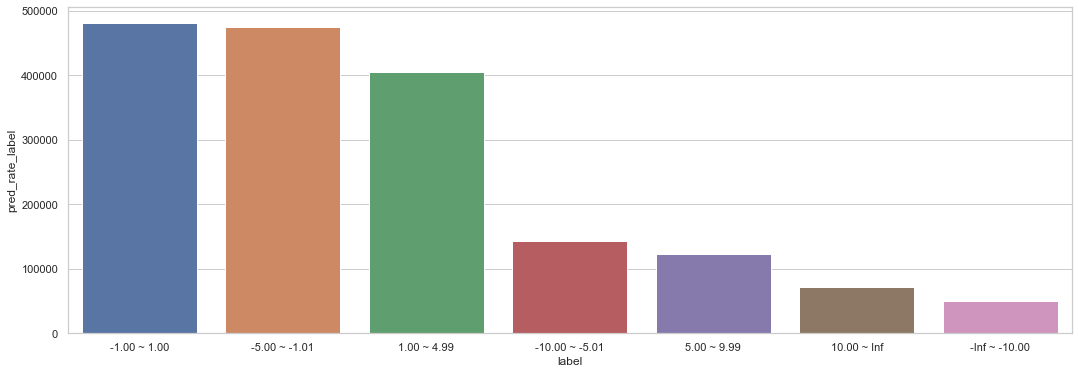

In [398]:
label_count = pd.DataFrame([stock_data.pred_rate_label.value_counts()]).T
label_count['label'] = label_count.index
plt.figure(figsize=(18,6))
import seaborn as sns
sns.set(style = 'whitegrid')
ax = sns.barplot(x='label', y='pred_rate_label', data=label_count)

In [399]:
# Label Setting
def label_to_numeric(x) : 
    if x == '-Inf ~ -10.00' : 
        result = 0
    elif x == '-10.00 ~ -5.01' : 
        result = 1
    elif x == '-5.00 ~ -1.01' : 
        result = 2
    elif x == '-1.00 ~ 1.00' : 
        result = 3
    elif x == '1.00 ~ 4.99' : 
        result = 4
    elif x == '5.00 ~ 9.99' : 
        result = 5
    else : 
        result = 6
    return result
        
# 함수 적용
stock_data['label'] = stock_data['pred_rate_label'].apply(lambda x : label_to_numeric(x))
stock_data

,trading_volume,trading_value,kindex,index,score,probability,pred_rate_label,label
0,0.086215,0.096147,2.641792e-05,0.035608,3.048529e-05,0.375694,-1.00 ~ 1.00,3
1,0.320222,0.349699,2.155739e-09,0.000540,2.647771e-09,0.260727,-10.00 ~ -5.01,1
2,0.316485,0.356655,2.155739e-09,0.000540,2.647771e-09,0.260727,-10.00 ~ -5.01,1
3,0.211185,0.238072,2.536944e-09,0.001319,3.023584e-09,0.265735,-5.00 ~ -1.01,2
4,0.164333,0.183067,2.616855e-09,0.001319,3.023584e-09,0.265735,1.00 ~ 4.99,4
...,...,...,...,...,...,...,...,...
6,0.000000,0.001407,1.413259e-01,0.000000,0.000000e+00,0.000000,-1.00 ~ 1.00,3
0,1.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,5.00 ~ 9.99,5
1,0.000000,0.000000,8.272858e-01,1.000000,1.000000e+00,1.000000,-Inf ~ -10.00,0
2,0.229922,0.293471,1.000000e+00,1.000000,1.000000e+00,1.000000,10.00 ~ Inf,6


### LightGBM

In [400]:
# Train Test Split
from sklearn.model_selection import train_test_split
X = stock_data[['trading_volume', 'trading_value', 'kindex', 'index', 'score', 'probability']].values
y = stock_data[['label']].values
y = y.reshape(-1)
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.1, random_state=1234)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train ,test_size=0.2, random_state=1234)

# HyperParameter
params = {
    'task' : 'train',
    'boosting_type' : 'gbdt',
    'objective' : 'multiclass',
    'metric' : {'multi_logloss'},
    'num_leaves' : 63,
    'learning_rate' : 0.1,
    'feature_fraction' : 0.9,
    'bagging_fraction' : 0.9,
    'bagging_freq': 0,
    'verbose' : 1,
    'num_class' : 7,
    'save_binary' : True
}

# Model Fitting
import lightgbm as lgb
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                early_stopping_rounds = 100)

[1]	valid_0's multi_logloss: 1.66157
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.65434
[3]	valid_0's multi_logloss: 1.64759
[4]	valid_0's multi_logloss: 1.64176
[5]	valid_0's multi_logloss: 1.63627
[6]	valid_0's multi_logloss: 1.63141
[7]	valid_0's multi_logloss: 1.62682
[8]	valid_0's multi_logloss: 1.62294
[9]	valid_0's multi_logloss: 1.61923
[10]	valid_0's multi_logloss: 1.61568
[11]	valid_0's multi_logloss: 1.61267
[12]	valid_0's multi_logloss: 1.61004
[13]	valid_0's multi_logloss: 1.60734
[14]	valid_0's multi_logloss: 1.60496
[15]	valid_0's multi_logloss: 1.60291
[16]	valid_0's multi_logloss: 1.60093
[17]	valid_0's multi_logloss: 1.59918
[18]	valid_0's multi_logloss: 1.59738
[19]	valid_0's multi_logloss: 1.59571
[20]	valid_0's multi_logloss: 1.59413
[21]	valid_0's multi_logloss: 1.59277
[22]	valid_0's multi_logloss: 1.5912
[23]	valid_0's multi_logloss: 1.58977
[24]	valid_0's multi_logloss: 1.58852
[25]	valid_0's multi_logloss: 1.587

[213]	valid_0's multi_logloss: 1.52491
[214]	valid_0's multi_logloss: 1.5247
[215]	valid_0's multi_logloss: 1.52452
[216]	valid_0's multi_logloss: 1.52431
[217]	valid_0's multi_logloss: 1.52413
[218]	valid_0's multi_logloss: 1.52388
[219]	valid_0's multi_logloss: 1.52372
[220]	valid_0's multi_logloss: 1.52353
[221]	valid_0's multi_logloss: 1.52335
[222]	valid_0's multi_logloss: 1.52312
[223]	valid_0's multi_logloss: 1.52293
[224]	valid_0's multi_logloss: 1.52276
[225]	valid_0's multi_logloss: 1.52254
[226]	valid_0's multi_logloss: 1.52232
[227]	valid_0's multi_logloss: 1.52211
[228]	valid_0's multi_logloss: 1.5219
[229]	valid_0's multi_logloss: 1.52169
[230]	valid_0's multi_logloss: 1.52153
[231]	valid_0's multi_logloss: 1.52135
[232]	valid_0's multi_logloss: 1.52118
[233]	valid_0's multi_logloss: 1.52103
[234]	valid_0's multi_logloss: 1.52083
[235]	valid_0's multi_logloss: 1.52054
[236]	valid_0's multi_logloss: 1.52031
[237]	valid_0's multi_logloss: 1.52012
[238]	valid_0's multi_loglo

[424]	valid_0's multi_logloss: 1.48776
[425]	valid_0's multi_logloss: 1.48759
[426]	valid_0's multi_logloss: 1.48741
[427]	valid_0's multi_logloss: 1.48725
[428]	valid_0's multi_logloss: 1.48711
[429]	valid_0's multi_logloss: 1.48698
[430]	valid_0's multi_logloss: 1.48683
[431]	valid_0's multi_logloss: 1.48671
[432]	valid_0's multi_logloss: 1.48656
[433]	valid_0's multi_logloss: 1.48638
[434]	valid_0's multi_logloss: 1.48623
[435]	valid_0's multi_logloss: 1.48603
[436]	valid_0's multi_logloss: 1.48588
[437]	valid_0's multi_logloss: 1.48575
[438]	valid_0's multi_logloss: 1.48561
[439]	valid_0's multi_logloss: 1.48546
[440]	valid_0's multi_logloss: 1.48534
[441]	valid_0's multi_logloss: 1.48515
[442]	valid_0's multi_logloss: 1.485
[443]	valid_0's multi_logloss: 1.48487
[444]	valid_0's multi_logloss: 1.48471
[445]	valid_0's multi_logloss: 1.48458
[446]	valid_0's multi_logloss: 1.48442
[447]	valid_0's multi_logloss: 1.48427
[448]	valid_0's multi_logloss: 1.48415
[449]	valid_0's multi_loglo

In [405]:
predictions = []
for x in gbm.predict(x_train):
    predictions.append(np.argmax(x))

y_train_pred = np.array(predictions).reshape(-1)
y_train_true = y_train

from sklearn.metrics import confusion_matrix
print("== Train Obs ==")
print('{:,} obs' .format(len(x_train)), end="\n\n")
print("== Train Error Matrix ==")
print(confusion_matrix(y_train_true, y_train_pred), end="\n\n")
print("== Train Accuracy ==")
acc = (8822 + 8666 + 243487 + 175691 + 85904 + 4567 + 6722) / len(y_train)
print("train accuracy : {:.2f}%" .format(acc * 100))

== Train Obs ==
1,259,136 obs

== Train Error Matrix ==
[[  8822    671  20917   2853   3229     22    132]
 [  1232   8666  72477   9032  11729     57    214]
 [  1087    915 243487  64557  30189    132    280]
 [   690    566 133601 175691  35191    139    242]
 [   783    689 135554  68358  85904    160    297]
 [   444    389  53295  10613  19337   4567    282]
 [   460    289  28980   4846  10245    102   6722]]

== Train Accuracy ==
0.4239883539188777


In [418]:
predictions = []
for x in gbm.predict(x_valid):
    predictions.append(np.argmax(x))

y_valid_pred = np.array(predictions).reshape(-1)
y_valid_true = y_valid

from sklearn.metrics import confusion_matrix
print("== Valid Obs ==")
print('{:,} obs' .format(len(x_valid)), end="\n\n")
print("== Valid Error Matrix ==")
print(confusion_matrix(y_valid_true, y_valid_pred), end="\n\n")
print("== Valid Accuracy ==")
acc = (1605 + 1437 + 58757 + 41977 + 18551 + 634 + 1037) / len(y_valid)
print("valid accuracy : {:.2f}%" .format(acc * 100))

== Valid Obs ==
314,784 obs

== Valid Error Matrix ==
[[ 1605   241  5653   761   843     8    35]
 [  364  1437 18471  2306  3107    17    86]
 [  340   361 58757 17041  8926    42    90]
 [  217   216 34701 41977  9546    41    68]
 [  233   227 35671 17980 18551    65   129]
 [  140   127 13350  2682  5036   634   110]
 [  144    98  7342  1243  2682    46  1037]]

== Valid Accuracy ==
valid acc : 39.39%


In [419]:
predictions = []
for x in gbm.predict(x_test):
    predictions.append(np.argmax(x))

y_test_pred = np.array(predictions).reshape(-1)
y_test_true = y_test

from sklearn.metrics import confusion_matrix
print("== Test Obs ==")
print('{:,} obs' .format(len(x_test)), end="\n\n")
print("== Test Error Matrix ==")
print(confusion_matrix(y_test_true, y_test_pred), end="\n\n")
print("== Test Accuracy ==")
acc = (828 + 802 + 32689 + 23706 + 10423 + 318 + 600) / len(y_test)
print("test accuracy : {:.2f}" .format(acc * 100))

== Test Obs ==
174,880 obs

== Test Error Matrix ==
[[  828   139  3031   391   491     2    31]
 [  221   802 10309  1315  1724    12    50]
 [  184   205 32689  9556  4887    32    59]
 [  113    96 19175 23706  5181    27    44]
 [  133   117 19525  9899 10423    36    54]
 [   66    74  7364  1516  2812   318    43]
 [   73    60  4160   706  1580    21   600]]

== Test Accuracy ==
test accuracy : 39.66


### Test 상승, 하락, 변화없음 3 Class로만 분류한 경우

In [420]:
Class3 = np.array([[828+139+3031+221+802+10309+184+205+32689, 391+1315+9556, 491+2+31+1724+12+50+4887+32+59],
                   [113+96+19175, 23706, 5181+27+44],
                   [133+117+19525+66+74+7364+73+60+4160, 9899+1516+706, 10423+36+54+2812+318+43+1580+21+600]])

print("== Up and Not and Down ==")
print(Class3, end="\n\n")

acc = (48408+23706+15887) / (48408+11262+7288+19384+23706+15252+31572+12121+15887)

print("Test 3 Class Accuracy = {:.2f}". format(acc*100))

== Up and Not and Down ==
[[48408 11262  7288]
 [19384 23706  5252]
 [31572 12121 15887]]

Test 3 Class Accuracy = 47.60


In [456]:
heatmap =pd.DataFrame(confusion_matrix(y_test_true, y_test_pred),
                      columns=['-Inf ~ -10.00', '-10.00 ~ -5.00', '-4.99 ~ -1.00', '-1.00 ~ 1.00', '1.00 ~ 5.00', '5.00 ~ 10.00', '10.0 ~ Inf'],
                      index = ['-Inf ~ -10.00', '-10.00 ~ -5.00', '-4.99 ~ -1.00', '-1.00 ~ 1.00', '1.00 ~ 5.00', '5.00 ~ 10.00', '10.0 ~ Inf'])

heatmap

,-Inf ~ -10.00,-10.00 ~ -5.00,-4.99 ~ -1.00,-1.00 ~ 1.00,1.00 ~ 5.00,5.00 ~ 10.00,10.0 ~ Inf
-Inf ~ -10.00,828,139,3031,391,491,2,31
-10.00 ~ -5.00,221,802,10309,1315,1724,12,50
-4.99 ~ -1.00,184,205,32689,9556,4887,32,59
-1.00 ~ 1.00,113,96,19175,23706,5181,27,44
1.00 ~ 5.00,133,117,19525,9899,10423,36,54
5.00 ~ 10.00,66,74,7364,1516,2812,318,43
10.0 ~ Inf,73,60,4160,706,1580,21,600


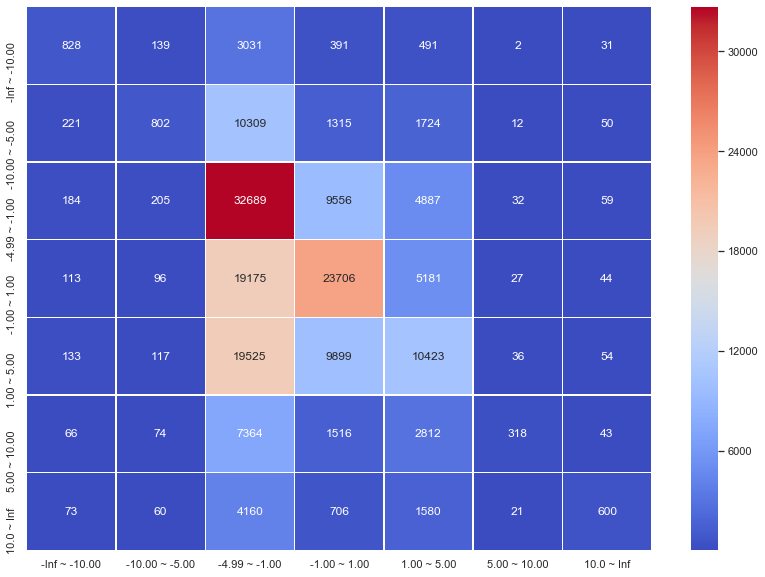

In [472]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(14,10))
map = sns.heatmap(heatmap, annot=True, fmt="d", linewidths=.5, ax=ax, cmap='coolwarm')
map.set_ylim(7,0)
plt.show()